In [1]:
import jax
import equinox as eqx
import numpy as np
import jax.numpy as jnp
import immrax as irx
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from immutabledict import immutabledict
from reach import *
from functools import partial

CVXPY_SOLVER = cp.MOSEK
# CVXPY_SOLVER = cp.SCS

# Some configurations
jax.config.update("jax_enable_x64", True)

# We wrap the jax.jit function to set the backend to cpu by default for convenience.
device = 'cpu'
def jit (*args, **kwargs):
    kwargs.setdefault('backend', device)
    return jax.jit(*args, **kwargs)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 14
})

In [2]:
class Robot (irx.System) :
    def __init__ (self) :
        self.xlen = 4
        self.evolution = 'continuous'

    def f(self, t, x):
        # Parameters from https://bitbucket.org/hurricanesoff/emsoft-code/src
        m = 1
        l = 3
        kp1 = 2
        kp2 = 1
        kd1 = 2
        kd2 = 1

        u1 = kp1
        u2 = kp2

        dx1 = x[2]
        dx2 = x[3]
        dx3 = (-2*m*x[1]*x[2]*x[3]-kp1*x[0]-kd1*x[2])/(m*x[1]*x[1]+l/3)+(kp1*u1)/(m*x[1]*x[1]+l/3)
        dx4 = x[1]*x[2]*x[2]-kp2*x[1]/m-kd2*x[3]/m+kp2*u2/m

        return jnp.array([dx1, dx2, dx3, dx4])

sys = Robot()

In [3]:
# Initial set taken from https://bitbucket.org/hurricanesoff/emsoft-code/src
P0 = jnp.array([[2.5063, -0.0276, 0.9436, 0.0280],
                [-0.0276, 2.4722, 0.0013, 0.9537],
                [ 0.9436, 0.0013, 2.2441, 0.0151],
                [ 0.0280, 0.9537, 0.0151, 2.2845]]) 
x0 = jnp.array([1.505, 1.505, 0.005, 0.005])

# For initial JITing
e0 = Ellipsoid(P0/jnp.array((0.01)**2), x0)
ix0 = iover(e0)

t0 = 0.     # Initial time
dt = 0.01   # Time step
tf = 10.    # Final time

sys_mjacM = irx.mjacM(sys.f)
sys_jacM = irx.jacM(sys.f)

perm = irx.Permutation((0, 3, 4, 1, 2))
# perm = irx.Permutation((0, 1, 2, 3, 4))

In [4]:
Dfx = jax.jit(lambda x : jax.jacfwd(sys.f, 1)(t0, x))
Mx = jax.jit(lambda ix : sys_mjacM(t0, ix)[0][1])
Dfx (x0)
M = Mx(ix0)

# Jitted get_sparse_corners since corner locations don't change.
from itertools import product
sh = M.shape
ic = jnp.isclose(M.lower.reshape(-1), M.upper.reshape(-1))
cs = [irx.Corner(p) for p in product(*[(0,) if ic[i] else (0,1) for i in range(len(ic))])]

@jit
def gsc (M) :
    M = M.reshape(-1)
    return [jnp.array([M.lower[i] if ci == 0 else M.upper[i] for i, ci in enumerate(c)]).reshape(sh) for c in cs]

M_c = gsc(M)

# Expecting 2^6 = 64 corners since 6 nonconstant elements in Jacobian matrix
print(f'{len(M_c)} corners')

16 corners


In [5]:

@jit
def rollout_undisturbed (xc) :
    # Euler integration of the dynamics for monte carlo simulations
    def step (carry, t) :
        xnomt = carry
        fc = sys.f(0., xnomt)
        xnomtp1 = xnomt + dt*fc
        return (xnomtp1, xnomtp1)

    tt = jnp.arange(0, tf+dt, dt)
    carry, xx = jax.lax.scan(step, xc, tt)

    return jnp.vstack((xc, xx))


Computed reachable set in 18.584995985031128s


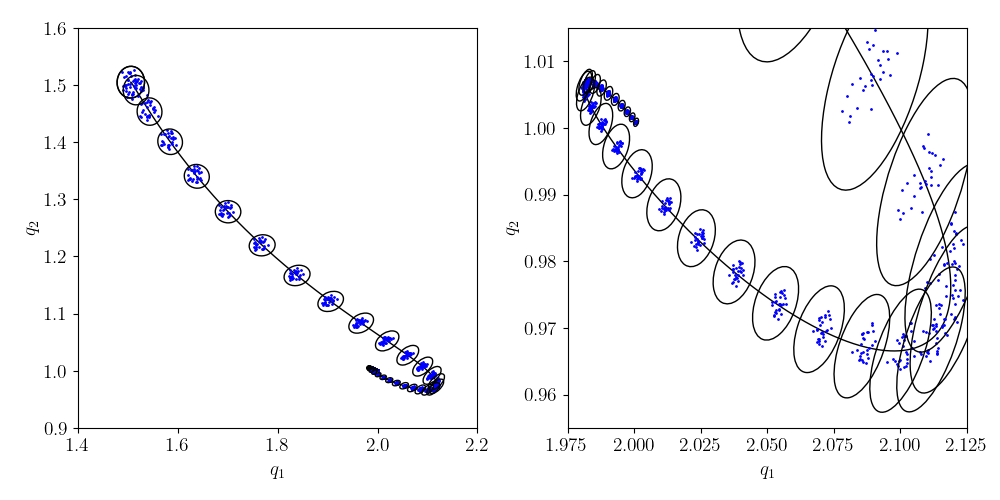

In [6]:
%matplotlib widget
from scipy.linalg import sqrtm, inv
import matplotlib.pyplot as plt
from math import floor

PLOT_EVERY = 25
LOG = False

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 14
})
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for ax in axs :
    ax.set_xlabel('$q_1$')
    ax.set_ylabel('$q_2$')

fig.tight_layout()

y0 = jnp.array((0.04)**2)
e0 = Ellipsoid(P0/y0, x0)

oxt = x0
at = sqrtm(P0)
yt = y0
Pt = at.T @ at

for ax in axs :
    e0.plot_projection(ax, 0, 1, color='black')
et = e0

# Monte Carlo simulations
mc_N = 100
mc_x0s = jnp.vstack((irx.utils.gen_ics(iover(e0), mc_N), x0))
mc_tf = tf
mc_dt = dt
mc_T = floor(mc_tf/mc_dt)
mc_trajs = jax.vmap(rollout_undisturbed)(mc_x0s)
for i in range(mc_N) :
    # Sampled initial conditions lie in the overapproximating interval of the initial ellipsoid
    # This check ensures the initial conditions are inside the ellipsoid
    if e0.V(mc_trajs[i, 0]) <= 1. :
        if PLOT_EVERY > 1 :
            for ax in axs :
                ax.scatter(mc_trajs[i, :mc_T:PLOT_EVERY, 0], mc_trajs[i, :mc_T:PLOT_EVERY, 1], c='b', s=1)
        else :
            for ax in axs :
                ax.plot(mc_trajs[i, :mc_T, 0], mc_trajs[i, :mc_T, 1], 'b', alpha=1., zorder=-1, lw=0.2)

# Plot the nominal trajectory
for ax in axs :
    ax.plot(mc_trajs[mc_N, :mc_T-PLOT_EVERY, 0], mc_trajs[mc_N, :mc_T-PLOT_EVERY, 1], 'black', alpha=1, zorder=-1, lw=1)

from time import time 
time0 = time()
timef = 0

for i, t in enumerate(np.arange(t0, tf, dt)) :
    ixt = iover(et)
    M = Mx(ixt)
    J = np.asarray(Dfx(oxt))
    M_c = gsc(M)

    # Setup optimization for offset dynamics
    c = cp.Variable()
    cons = [(M.T - J.T) @ Pt + Pt @ (M - J) << c*Pt for M in M_c]
    prob = cp.Problem(cp.Minimize(c), cons)
    if CVXPY_SOLVER == cp.MOSEK :
        prob.solve(solver=CVXPY_SOLVER, warm_start=True, mosek_params={'MSK_IPAR_NUM_THREADS': 10})
    else :
        prob.solve(solver=CVXPY_SOLVER, warm_start=True)

    if LOG :
        print(i, t, prob.status, f'c={c.value}')

    # Euler integrating the embedding system
    at = (at - dt*at@J)
    oxt = oxt + dt*sys.f(t, oxt)
    yt = yt*np.exp(dt*c.value)

    currt = time()
    timef += currt - time0
    time0 = currt

    Pt = at.T @ at
    et = Ellipsoid(Pt/yt, oxt)
    if i % PLOT_EVERY == 0 :
        for ax in axs :
            et.plot_projection(ax, 0, 1, color='black')

print(f'Computed reachable set in {timef}s')

axs[0].set_xlim(1.4, 2.2)
axs[0].set_ylim(0.9, 1.6)
axs[1].set_xlim(1.975, 2.125)
axs[1].set_ylim(0.955, 1.015)

fig.savefig('figures/RobotArmAdjoint.pdf')
fig.savefig('figures/RobotArmAdjoint.svg')
fig.savefig('figures/RobotArmAdjoint.png', dpi=300)